In [2]:
import pandas as pd
import numpy as np
import random
import networkx as nx
import community
import matplotlib.pyplot as plt
from faker import Faker
import joblib

## synthetic sample

    # !pip install faker

In [3]:
def generate_synthetic_network(num_users, avg_friends, bipartite=False):
    """
    Generate a synthetic social network using the NetworkX library.

    Parameters:
        num_users (int): The number of users in the network.
        avg_friends (int): The average number of friends each user should have.
        bipartite (bool, optional): If True, generates a bipartite network with separate user and sharer groups. 
                                    If False, generates a non-bipartite network. Default is False.

    Returns:
        networkx.Graph: A networkx.Graph object representing the synthetic social network.

    Notes:
        - If `bipartite` is True, the number of users should be greater than or equal to 2*num_users.
          Otherwise, it will fall back to a non-bipartite network.
        - The average number of friends per user is determined by `avg_friends`.
          The actual number of friends will be randomly chosen between `avg_friends // 2` and `avg_friends * 2`.
        - The generated network may contain isolated nodes (users without any friends).
        - In a bipartite network, users from one group will only be connected to users from the other group.

    """
    fake = Faker()
    users = [fake.user_name() for i in range(1, num_users + 1)]

    G = nx.Graph()
    
    if not bipartite:
        G.add_nodes_from(users)
        for i, codename in enumerate(users):
            num_friends = random.randint(avg_friends // 2, avg_friends * 2)
            friends = random.sample(users, num_friends)
            G.add_edges_from([(codename, friend) for friend in friends
                              if friend!=codename])
    else:
        sharers = [fake.user_name() for i in range(1, num_users + 1)]
        sharers = [x for x in sharers if x not in users]
        G.add_nodes_from(users, bipartite=0)
        G.add_nodes_from(sharers, bipartite=1)
        for i, codename in enumerate(users):
            num_friends = random.randint(avg_friends // 2, avg_friends * 2)
            friends = random.sample(sharers, num_friends)
            G.add_edges_from([(codename, friend) for friend in friends])        
    return G

### simple friendship network

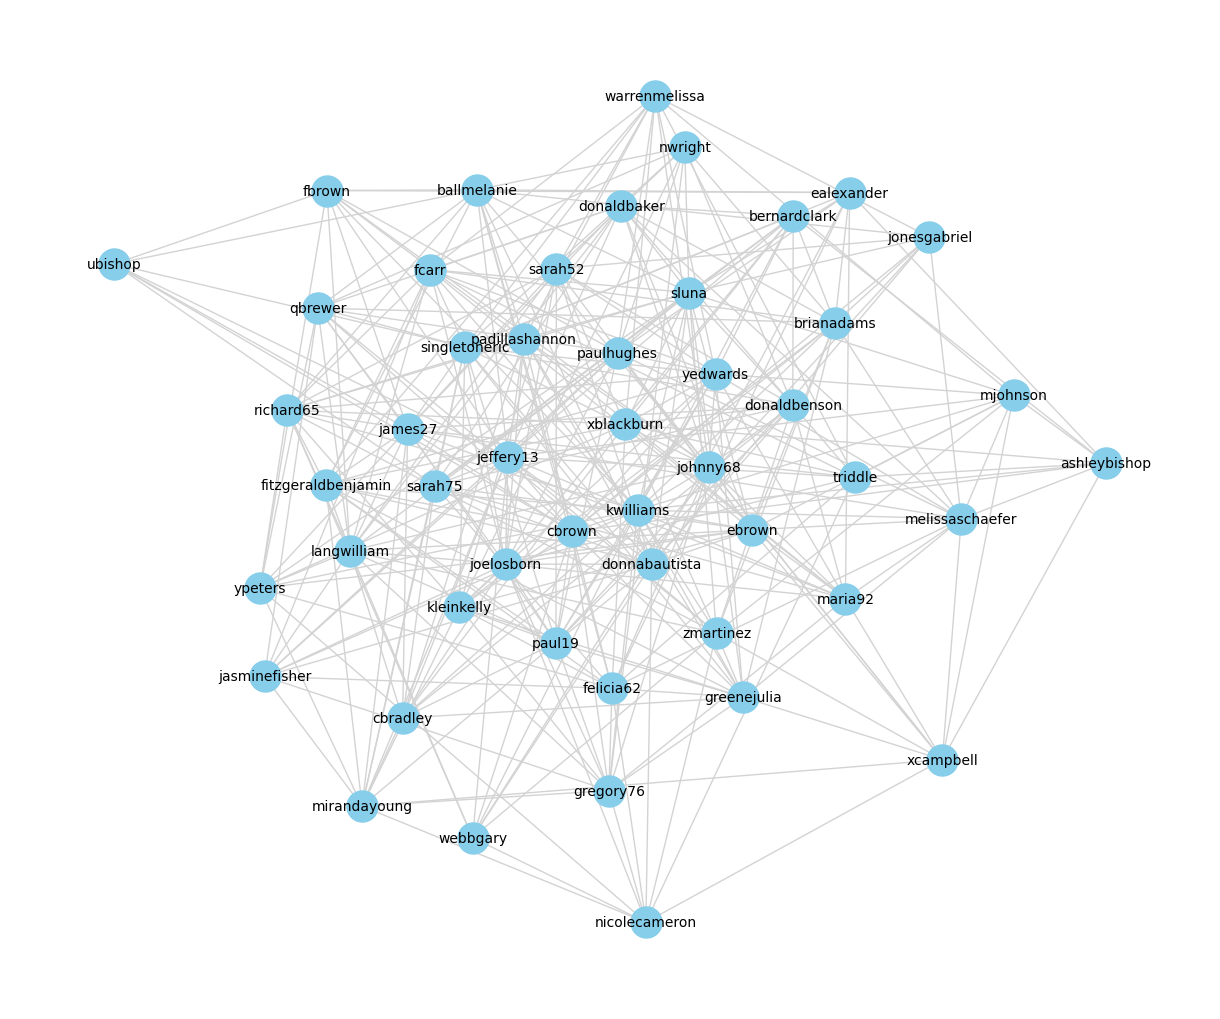

In [4]:
fn = "Synthetic Network of 100 Codenamed Individuals Facebook Friendships"

# network = generate_synthetic_network(50, 6)

network = joblib.load('friends-network.pkl')
# joblib.dump(network, 'friends-network.pkl')

fig = plt.figure(figsize=(12, 10))
pos = nx.spring_layout(network, seed=42)
nx.draw(network, pos, with_labels=True, edge_color='lightgray',
        node_color='skyblue', node_size=500, font_size=10)

fig.savefig(f"{'-'.join(fn.lower().split())}.png", dpi=200)
plt.show()

### bipartite graph of source and sharers

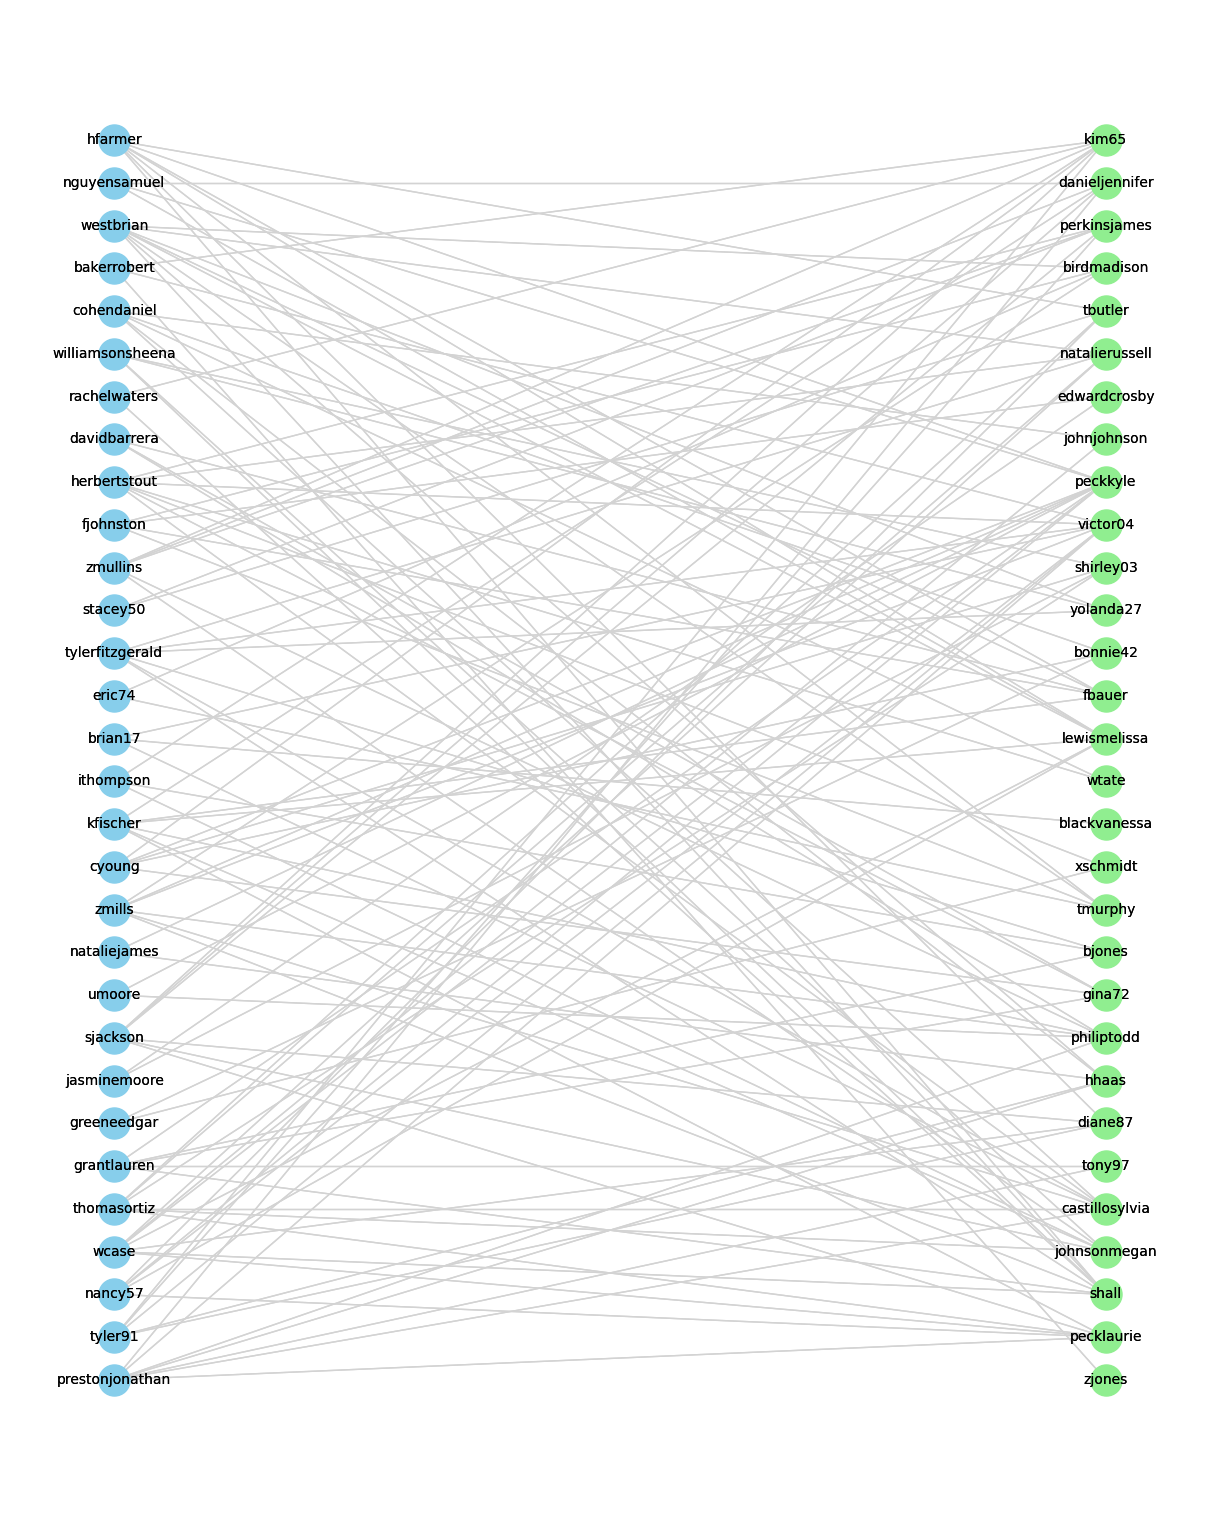

In [5]:
fn = 'Bipartite of Facebook Sharers and Sources'

# network = generate_synthetic_network(30, 4, True)

network = joblib.load('bipartite-network.pkl')
# joblib.dump(network, 'bipartite-network.pkl')

user_nodes = {node for node, data in network.nodes(data=True)
                      if data['bipartite'] == 0}
sharer_nodes = {node for node, data in network.nodes(data=True) 
                if data['bipartite'] == 1}

fig = plt.figure(figsize=(12, 15))
pos = nx.bipartite_layout(network, user_nodes)

nx.draw(network, pos, with_labels=True, edge_color='lightgray',
        nodelist=user_nodes, node_color='skyblue', node_size=500, 
        font_size=10)

nx.draw(network, pos, with_labels=True, edge_color='lightgray',
        nodelist=sharer_nodes, node_color='lightgreen', node_size=500,
        font_size=10)

fig.savefig(f"{'-'.join(fn.lower().split())}.png", dpi=200)
plt.show()

In [6]:
# neighbors of nguyensamuel
list(network.neighbors('nguyensamuel'))

['lewismelissa', 'peckkyle', 'danieljennifer']

In [7]:
# neighbors of nataliejames
list(network.neighbors('nataliejames'))

['peckkyle', 'hhaas']

### projected onto source nodes - shared audience

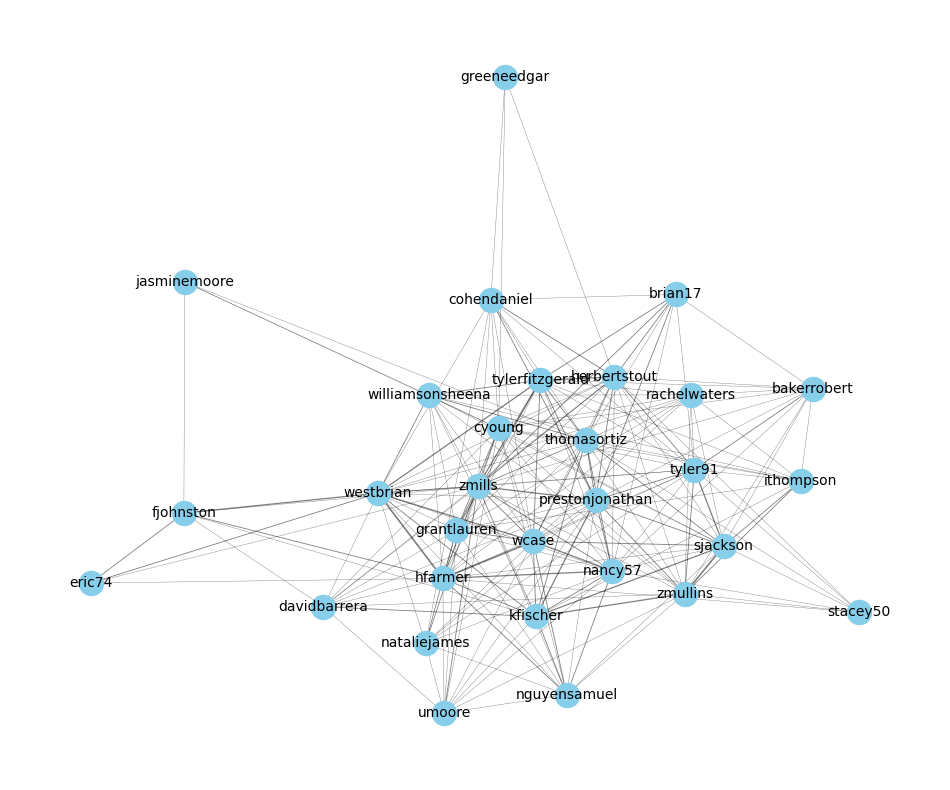

In [8]:
fn = 'Projection Shared Audience'
shared_audience_network = nx.bipartite.weighted_projected_graph(network,
                                                                user_nodes)

# joblib.dump(shared_audience_network, 'shared-audience-network.pkl')

fig = plt.figure(figsize=(12, 10))
plt.axis('off')

pos = nx.spring_layout(shared_audience_network, seed=42) 

nx.draw_networkx_nodes(shared_audience_network, pos, node_size=300, 
                       node_color='skyblue')

nx.draw_networkx_labels(shared_audience_network, pos, font_color='black',
                        font_size=10)

edge_width = [0.3 * shared_audience_network[u][v]['weight'] 
              for u, v in shared_audience_network.edges()]

nx.draw_networkx_edges(shared_audience_network, pos, alpha=0.5,
                       width=edge_width)

fig.savefig(f"{'-'.join(fn.lower().split())}.png", dpi=200)
plt.show()

### projected onto sharer nodes - shared sources

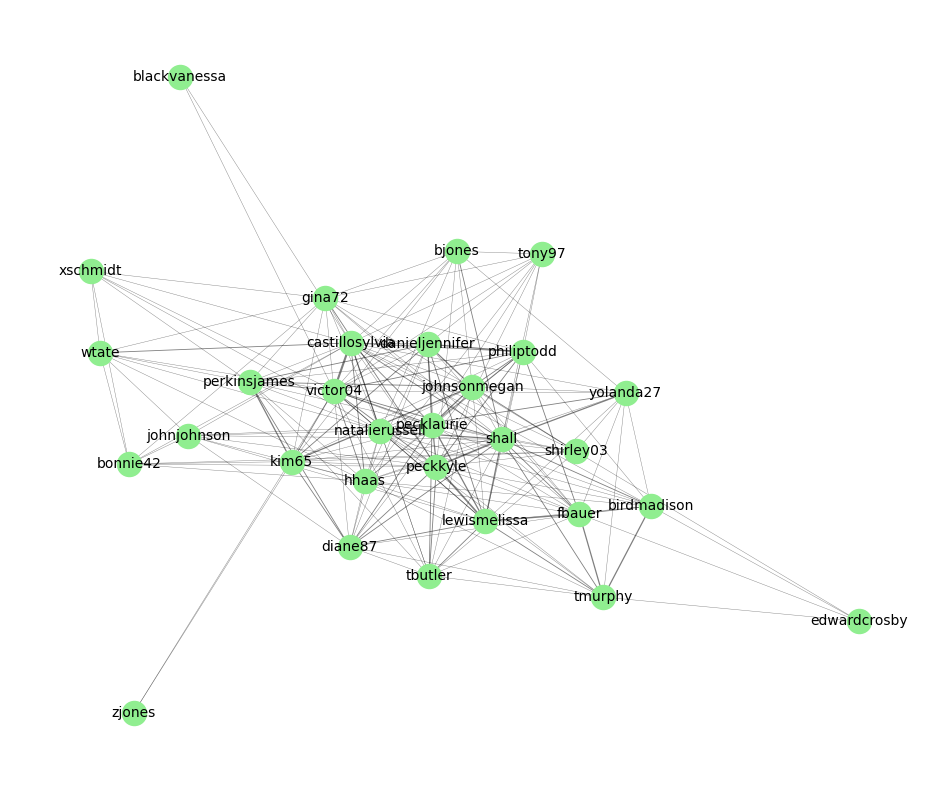

In [9]:
fn = 'Projection Shared Sources'

shared_source_network = nx.bipartite.weighted_projected_graph(network,
                                                                sharer_nodes)

# joblib.dump(shared_source_network, 'shared-sources-network.pkl')

fig = plt.figure(figsize=(12, 10))
plt.axis('off')

pos = nx.spring_layout(shared_source_network, seed=0) 

nx.draw_networkx_nodes(shared_source_network, pos, node_size=300, 
                       node_color='lightgreen')

nx.draw_networkx_labels(shared_source_network, pos, font_color='black',
                        font_size=10)

edge_width = [0.3 * shared_source_network[u][v]['weight'] 
              for u, v in shared_source_network.edges()]

nx.draw_networkx_edges(shared_source_network, pos, alpha=0.5,
                       width=edge_width)

fig.savefig(f"{'-'.join(fn.lower().split())}.png", dpi=200)
plt.show()

### sample measures for the shared source network

In [10]:
clustering_coefficient = nx.average_clustering(shared_source_network)
print(f'Clustering Coefficient: {clustering_coefficient:.2f}')

Clustering Coefficient: 0.67


In [11]:
degree_centrality = nx.degree_centrality(shared_source_network)
betweenness_centrality = nx.betweenness_centrality(shared_source_network)
eigenvector_centrality = nx.eigenvector_centrality(shared_source_network)

sorted_degree = sorted(degree_centrality.items(),
                             key=lambda x: x[1], reverse=True)

sorted_betweenness = sorted(betweenness_centrality.items(),
                                  key=lambda x: x[1], reverse=True)

sorted_eigenvector = sorted(eigenvector_centrality.items(),
                                key=lambda x: x[1], reverse=True)

df_degree = pd.DataFrame(sorted_degree,
                               columns=['User', 'Degree_Centrality'])

df_betweenness = pd.DataFrame(sorted_betweenness,
                                columns=['User', 'Betweenness_Centrality'])

df_eigenvector = pd.DataFrame(sorted_eigenvector,
                                  columns=['User', 'Eigenvector_Centrality'])

print("Top users based on their degree centrality:")
display(df_degree.head())

print("\nTop users based on their betweenness centrality:")
display(df_betweenness.head())

print("\nTop users based on their eigenvector centrality:")
display(df_eigenvector.head())

Top users based on their degree centrality:


User  Degree_Centrality
0  castillosylvia           0.758621
1        victor04           0.758621
2           shall           0.724138
3        peckkyle           0.724138
4  natalierussell           0.724138


Top users based on their betweenness centrality:


User  Betweenness_Centrality
0        victor04                0.108744
1  castillosylvia                0.080263
2  natalierussell                0.047148
3        peckkyle                0.038700
4           hhaas                0.038322


Top users based on their eigenvector centrality:


User  Eigenvector_Centrality
0           shall                0.264470
1        peckkyle                0.260174
2  natalierussell                0.255049
3        victor04                0.251580
4  castillosylvia                0.249191

### visualizations for the centrality measures

#### degree centrality

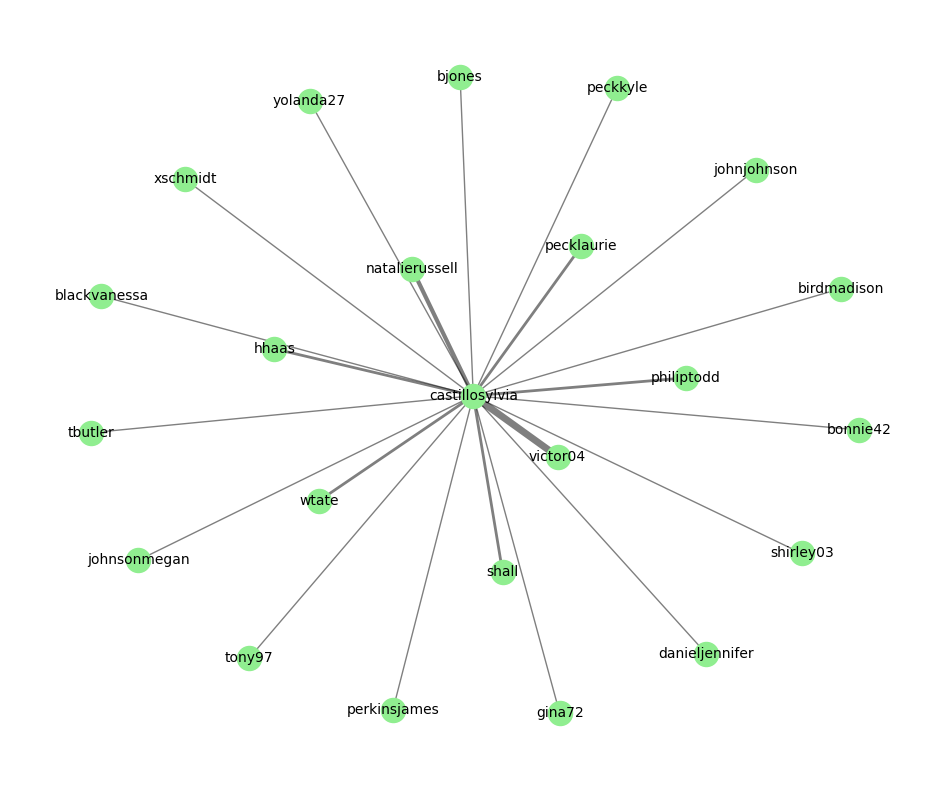

In [12]:
selected_node = 'castillosylvia'  

ego_network = nx.ego_graph(shared_source_network, selected_node, radius=1)

neighbors = list(ego_network.neighbors('castillosylvia'))

filtered_network = nx.Graph()
filtered_network.add_nodes_from(neighbors + [selected_node])

u = selected_node
for v in neighbors:
    filtered_network.add_edge(u, v, weight=ego_network[u][v]['weight'])

fig = plt.figure(figsize=(12, 10))
plt.axis('off')

pos = nx.spring_layout(filtered_network, seed=0) 

nx.draw_networkx_nodes(filtered_network, pos, node_size=300, node_color='lightgreen')
nx.draw_networkx_labels(filtered_network, pos, font_color='black', font_size=10)

edge_width = [filtered_network[u][v]['weight'] for u, v in filtered_network.edges()]

nx.draw_networkx_edges(filtered_network, pos, alpha=0.5, width=edge_width)

fig.savefig(f"{selected_node.lower()}degree.png", dpi=200)
plt.show()

#### betweenness centrality

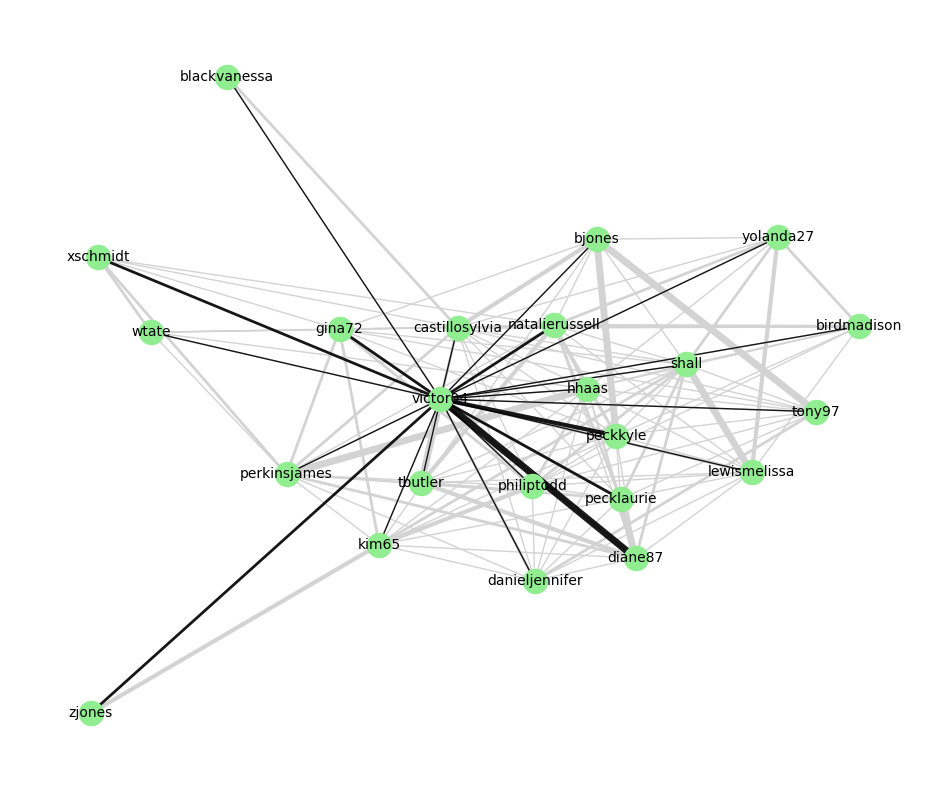

In [13]:
selected_node = 'victor04'
ego_network = nx.ego_graph(shared_source_network, selected_node, radius=1)

ego_network_copy = ego_network.copy()

fig = plt.figure(figsize=(12, 10))
plt.axis('off')

pos = nx.spring_layout(ego_network, seed=0)

ego_network_copy.remove_node(selected_node)

missing_edges = [edge for edge in ego_network.edges() if edge not in ego_network_copy.edges()]

nx.draw_networkx_nodes(ego_network, pos, node_size=300, node_color='lightgreen')
nx.draw_networkx_labels(ego_network, pos, font_color='black', font_size=10)

nx.draw_networkx_edges(ego_network, pos, edgelist=ego_network.edges(), edge_color='lightgray', width=edge_width)

nx.draw_networkx_edges(ego_network_copy, pos, edgelist=missing_edges, edge_color='black', width=edge_width, alpha=0.9)

fig.savefig(f"{selected_node.lower()}betweenness-adj.png", dpi=200)
plt.show()


#### eigenvector centrality

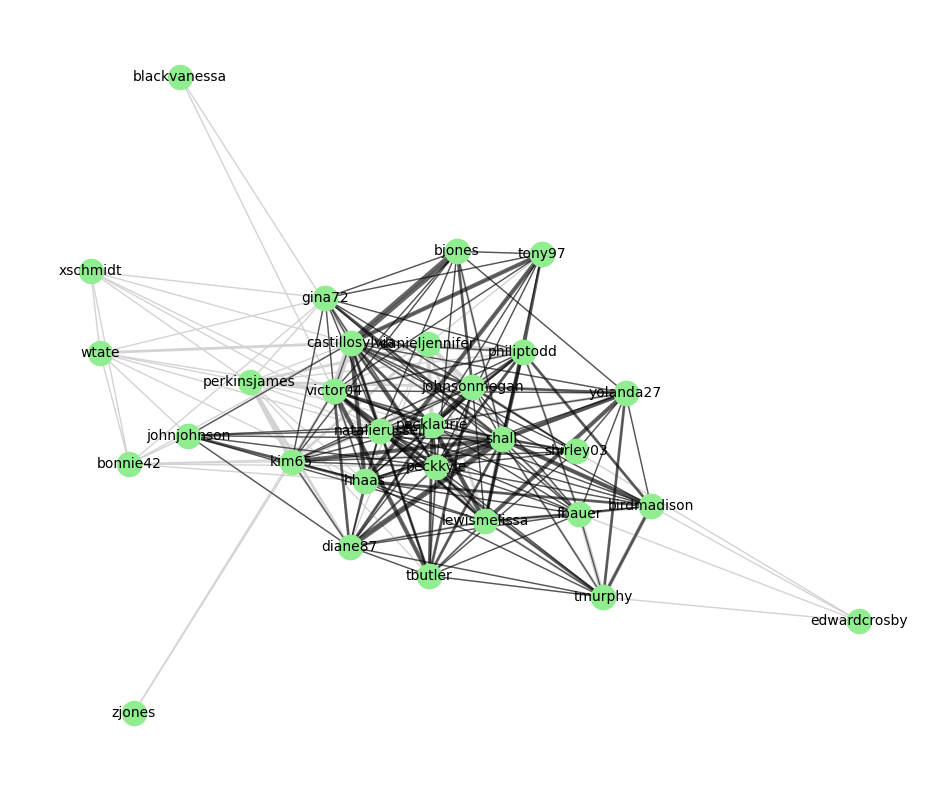

In [14]:
selected_node = 'shall'
ego_network = nx.ego_graph(shared_source_network, selected_node, radius=1)

ego_network_copy = ego_network.copy()

fig = plt.figure(figsize=(12, 10))
plt.axis('off')

pos = nx.spring_layout(shared_source_network, seed=0)

missing_edges = [edge for edge in ego_network_copy.edges() if edge not in ego_network.edges()]

nx.draw_networkx_nodes(shared_source_network, pos, node_size=300, node_color='lightgreen')
nx.draw_networkx_labels(shared_source_network, pos, font_color='black', font_size=10)

edge_width = [shared_source_network[u][v]['weight'] for u, v in shared_source_network.edges()]

nx.draw_networkx_edges(shared_source_network, pos, edgelist=shared_source_network.edges(), edge_color='lightgray', width=edge_width)

nx.draw_networkx_nodes(ego_network_copy, pos, nodelist=ego_network.nodes(), node_size=300, node_color='lightgreen')
nx.draw_networkx_edges(ego_network_copy, pos, edgelist=ego_network.edges(), edge_color='black', alpha=0.6, width=edge_width)

fig.savefig(f"{selected_node.lower()}eigen.png", dpi=200)
plt.show()


## real-world data - facebook sharing

In [16]:
total_data = pd.read_csv('data-total.csv')
total_data.shape

(8983, 5)

In [17]:
def create_bipartite_graph_from_data(bipartite_0, bipartite_1, edges):
    """
    Create a bipartite graph from given node sets and edges.

    Parameters:
        bipartite_0 (list or iterable): List of nodes for the first group (bipartite=0).
        bipartite_1 (list or iterable): List of nodes for the second group (bipartite=1).
        edges (list or iterable): List of edges, where each edge is a tuple (node_a, node_b).

    Returns:
        networkx.Graph: A bipartite graph with nodes and edges as specified.
    """
    network = nx.Graph()
    network.add_nodes_from(bipartite_1, bipartite=1)
    network.add_nodes_from(bipartite_0, bipartite=0)
    network.add_edges_from(edges)
    return network


def network_statistics(network, color='lightcoral'):
    """
    Calculate and visualize statistics for a given network.

    Parameters:
        network (networkx.Graph): The input network represented as a NetworkX Graph object.
        color (str, optional): Color for the histogram plot. Default is 'lightcoral'.

    Returns:
        None

    Prints:
        - Network density: The density of the network, which represents the ratio of actual edges to possible edges.
        - Average Shortest Path Length: The average length of the shortest paths between all pairs of nodes.
        - Clustering Coefficient: The average clustering coefficient of the nodes in the network.
        - Average Degree: The average degree of nodes in the network.
    
    Visualizes:
        - Histogram of node degrees, displaying the frequency of nodes with a certain degree in the network.
        - Vertical dashed line representing the average degree of the network.

    Notes:
        - If the network is disconnected, the Average Shortest Path Length calculation will raise an exception, and it will be skipped.
        - The network statistics provide insights into the structure and characteristics of the network.
        - The histogram of node degrees helps to understand the distribution of node degrees in the network.
        - The function does not return any value; it prints statistics and shows the histogram.
        
    """
    # Network Density
    density = nx.density(network)
    print(f'Network Density: {density:.2f}')

    # Average Shortest Path Length
    try:
        avg_shortest_path_length = nx.average_shortest_path_length(network)
        print(f'Average Shortest Path Length: {avg_shortest_path_length:.2f}')
    except:
        pass
    
    # Clustering Coefficient
    clustering_coefficient = nx.average_clustering(network)
    print(f'Clustering Coefficient: {clustering_coefficient:.2f}')
    
    # Compute average degree
    degree_counts = dict(nx.degree(network))
    average_degree = np.mean(list(degree_counts.values()))
    print(f'Average Degree: {average_degree:.2f}')

    # Histogram of degree counts
    degrees = list(degree_counts.values())

    plt.figure(figsize=(10, 6))
    plt.hist(degrees, color=color, bins=200)
    plt.axvline(x=average_degree, color='k', linestyle='dashed',
                linewidth=2, label='Average Degree')

    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.title('Node Degree Distribution')
    plt.legend()
    plt.show()
    

def create_projections(bipartite_network, source_nodes, sharer_nodes):
    """
    Create projections of a bipartite network onto its two node sets.

    Parameters:
        bipartite_network (networkx.Graph): The bipartite network represented as a NetworkX Graph object.
        source_nodes (list or iterable): List of nodes from the first node set (e.g., source nodes).
        sharer_nodes (list or iterable): List of nodes from the second node set (e.g., sharer nodes).

    Returns:
        tuple: A tuple containing two projected networks.
            - shared_audience_network (networkx.Graph): A weighted projected graph on the source_nodes, 
                                                      representing the shared audience among the source_nodes.
            - shared_source_network (networkx.Graph): A weighted projected graph on the sharer_nodes, 
                                                     representing the shared sources among the sharer_nodes.
    """
    shared_audience_network = nx.bipartite.weighted_projected_graph(
        total_network, source_nodes
    )
    
    shared_source_network = nx.bipartite.weighted_projected_graph(
        total_network, sharer_nodes
    )
    
    return shared_audience_network, shared_source_network

    
def plot_network(network, fn='Network Graph', color='skyblue',
                 cmap=None, show_labels=False, show_communities=False):
    """
    Plot a network graph with various options.

    Parameters:
        network (networkx.Graph): The input network represented as a NetworkX Graph object.
        fn (str, optional): The filename to save the plot. Default is 'Network Graph'.
        color (str or list, optional): Node color for the plot. Default is 'skyblue'.
        cmap (matplotlib colormap, optional): Colormap for node coloring when showing communities. 
                                              Default is None, which uses plt.cm.tab20 colormap.
        show_labels (bool, optional): If True, display node labels on the plot. Default is False.
        show_communities (bool, optional): If True, detect and display communities using the Louvain method. 
                                           Default is False.

    Returns:
        dict or None: If `show_communities` is True, returns a dictionary containing node-to-community mapping.
    """
    fig = plt.figure(figsize=(12, 10))
    plt.axis('off')
    pos = nx.spring_layout(network, seed=42)
    
    if show_communities:
        if cmap is None:
            cmap = plt.cm.tab20
        partition = community.best_partition(network)
        node_colors = [partition[node] for node in network.nodes()]
        nx.draw_networkx_nodes(network, pos, node_size=25, 
                               node_color=node_colors, cmap=cmap)

    else:
        nx.draw_networkx_nodes(network, pos, node_size=25, node_color=color)
        
    if show_labels:
        labels = {node: node for node in network.nodes()}
        nx.draw_networkx_labels(network, pos, labels=labels)

    edge_width = [0.3 * network[u][v]['weight'] for u, v in network.edges()]

    nx.draw_networkx_edges(network, pos, alpha=0.5, width=edge_width)

    fig.savefig(f"{'-'.join(fn.lower().split())}.png", dpi=200)
    plt.show()
    
    if show_communities:
        return partition
    
    
def plot_bipartite(bipartite_network, source_nodes, sharer_nodes,
                   fn='Bipartite Graph', color1='skyblue', 
                   color2='lightcoral', bipartite_layout=True):
    """
    Plot a bipartite graph with options to customize the layout.

    Parameters:
        bipartite_network (networkx.Graph): The bipartite network represented as a NetworkX Graph object.
        source_nodes (list or iterable): List of nodes from the first node set (e.g., source nodes).
        sharer_nodes (list or iterable): List of nodes from the second node set (e.g., sharer nodes).
        fn (str, optional): The filename to save the plot. Default is 'Bipartite Graph'.
        color1 (str, optional): Node color for the first node set. Default is 'skyblue'.
        color2 (str, optional): Node color for the second node set. Default is 'lightcoral'.
        bipartite_layout (bool, optional): If True, use bipartite layout with fixed positions for the two node sets. 
                                           If False, use spring layout to arrange nodes. Default is True.

    Returns:
        None

    """
    
    if bipartite_layout:
        fig = plt.figure(figsize=(12, 15))
        pos = nx.bipartite_layout(bipartite_network, source_nodes)

        nx.draw(bipartite_network, pos, with_labels=False, 
                nodelist=source_nodes, node_color=color1, node_size=10,
                alpha=0.5)

        nx.draw(bipartite_network, pos, with_labels=False, 
                nodelist=sharer_nodes, node_color=color2, node_size=10,
                alpha=0.5)

        fig.savefig(f"{'-'.join(fn.lower().split())}.png", dpi=200)
        plt.show()
    
    else:
        fig = plt.figure(figsize=(12, 10))
        pos = nx.spring_layout(bipartite_network)

        nx.draw(bipartite_network, pos, with_labels=False,
                nodelist=source_nodes, node_color=color1, node_size=10,
                alpha=0.5)

        nx.draw(bipartite_network, pos, with_labels=False, 
                nodelist=sharer_nodes, node_color=color2, node_size=10,
                alpha=0.5)

        fig.savefig(f"{'-'.join(fn.lower().split())}.png", dpi=200)
        plt.show()
     
    
def filter_network(network, min_degree_threshold=10):
    """
    Filter a network by removing nodes with degrees below a given threshold.

    Parameters:
        network (networkx.Graph): The input network represented as a NetworkX Graph object.
        min_degree_threshold (int, optional): The minimum degree threshold for nodes to be kept in the filtered network.
                                              Nodes with degrees less than this value will be removed.
                                              Default is 10.

    Returns:
        networkx.Graph: A subgraph of the input network containing only nodes with degrees greater than or equal to
                        the `min_degree_threshold`.
    """
    filtered_nodes = [node for node, degree in network.degree()
                      if degree >= min_degree_threshold]
    
    filtered_network = network.subgraph(filtered_nodes)
    return filtered_network


def get_influential_nodes(network, n=10, community_labels=None):
    """
    Get the most influential nodes in the network based on different centrality measures.

    Parameters:
        network (networkx.Graph): The input network represented as a networkx graph.
        n (int, optional): The number of top influential nodes to return for each centrality measure. Default is 10.
        community_labels (list, optional): A list containing the community label for each node in the network.
                                           If provided, the function will calculate centrality measures for each community separately.
                                           Default is None, which calculates global centrality measures for the entire network.

    Returns:
        community_sizes (dict): Dictionary for sizes of communities.
        degree_df (pandas.DataFrame): A DataFrame containing nodes sorted by degree centrality in descending order.
        betweenness_df (pandas.DataFrame): A DataFrame containing nodes sorted by betweenness centrality in descending order.
        eigen_df (pandas.DataFrame): A DataFrame containing nodes sorted by eigenvector centrality in descending order.

    Note:
        The function uses three centrality measures to identify influential nodes:
    """
    degree_centrality = nx.degree_centrality(network)
    betweenness_centrality = nx.betweenness_centrality(network)
    eigenvector_centrality = nx.eigenvector_centrality(network)
    
    if community_labels is None:
        sorted_degree = sorted(degree_centrality.items(),
                             key=lambda x: x[1], reverse=True)

        sorted_betweenness = sorted(betweenness_centrality.items(),
                                          key=lambda x: x[1], reverse=True)

        sorted_eigen = sorted(eigenvector_centrality.items(),
                                        key=lambda x: x[1], reverse=True)

        degree_df = pd.DataFrame(sorted_degree,
                                columns=['Node', 'Degree_Centrality'])

        betweenness_df = pd.DataFrame(sorted_betweenness,
                                columns=['Node', 'Betweenness_Centrality'])

        eigen_df = pd.DataFrame(sorted_eigen,
                                columns=['Node', 'Closeness_Centrality'])
 
        
    else:
        community_sizes = {community_id: sum(1 for label in community_labels.values() 
                                             if label == community_id)
                           for community_id in set(community_labels.values())}

        nodes_by_community = {community_id: [node for node, label in community_labels.items()
                              if label == community_id] 
                              for community_id in set(community_labels.values())}

        top_n_nodes_per_community = {}
        for community_id, nodes in nodes_by_community.items():
            top_n_nodes_per_community[community_id] = sorted(nodes, key=lambda node: degree_centrality[node], reverse=True)[:n]

        top_n_betweenness_nodes_per_community = {}
        for community_id, nodes in nodes_by_community.items():
            top_n_betweenness_nodes_per_community[community_id] = sorted(nodes, key=lambda node: betweenness_centrality[node], reverse=True)[:n]

        top_n_eigen_nodes_per_community = {}
        for community_id, nodes in nodes_by_community.items():
            top_n_eigen_nodes_per_community[community_id] = sorted(nodes, key=lambda node: eigenvector_centrality[node], reverse=True)[:n]

        degree_df = pd.DataFrame.from_dict(top_n_nodes_per_community, orient='columns')
        betweenness_df = pd.DataFrame.from_dict(top_n_betweenness_nodes_per_community, orient='columns')
        eigen_df = pd.DataFrame.from_dict(top_n_eigen_nodes_per_community, orient='columns')

    print('\nBy degree centrality:\n')
    display(degree_df)

    print('\nBy betweenness centrality:\n')
    display(betweenness_df)

    print('\nBy eigenvector centrality:\n')
    display(eigen_df)
    
    return community_sizes, degree_df, betweenness_df, eigen_df

### bipartite

In [18]:
sources = total_data['source_name'].unique().tolist()
linkers = [x for x in total_data['linker_name'].unique() if x not in sources]
total_edges = total_data[['source_name',
                          'linker_name']].to_records(index=False).tolist()

total_network = create_bipartite_graph_from_data(bipartite_0=linkers,
                                                 bipartite_1=sources,
                                                 edges=total_edges)

joblib.dump(total_network, 'total-network.pkl')

['total-network.pkl']

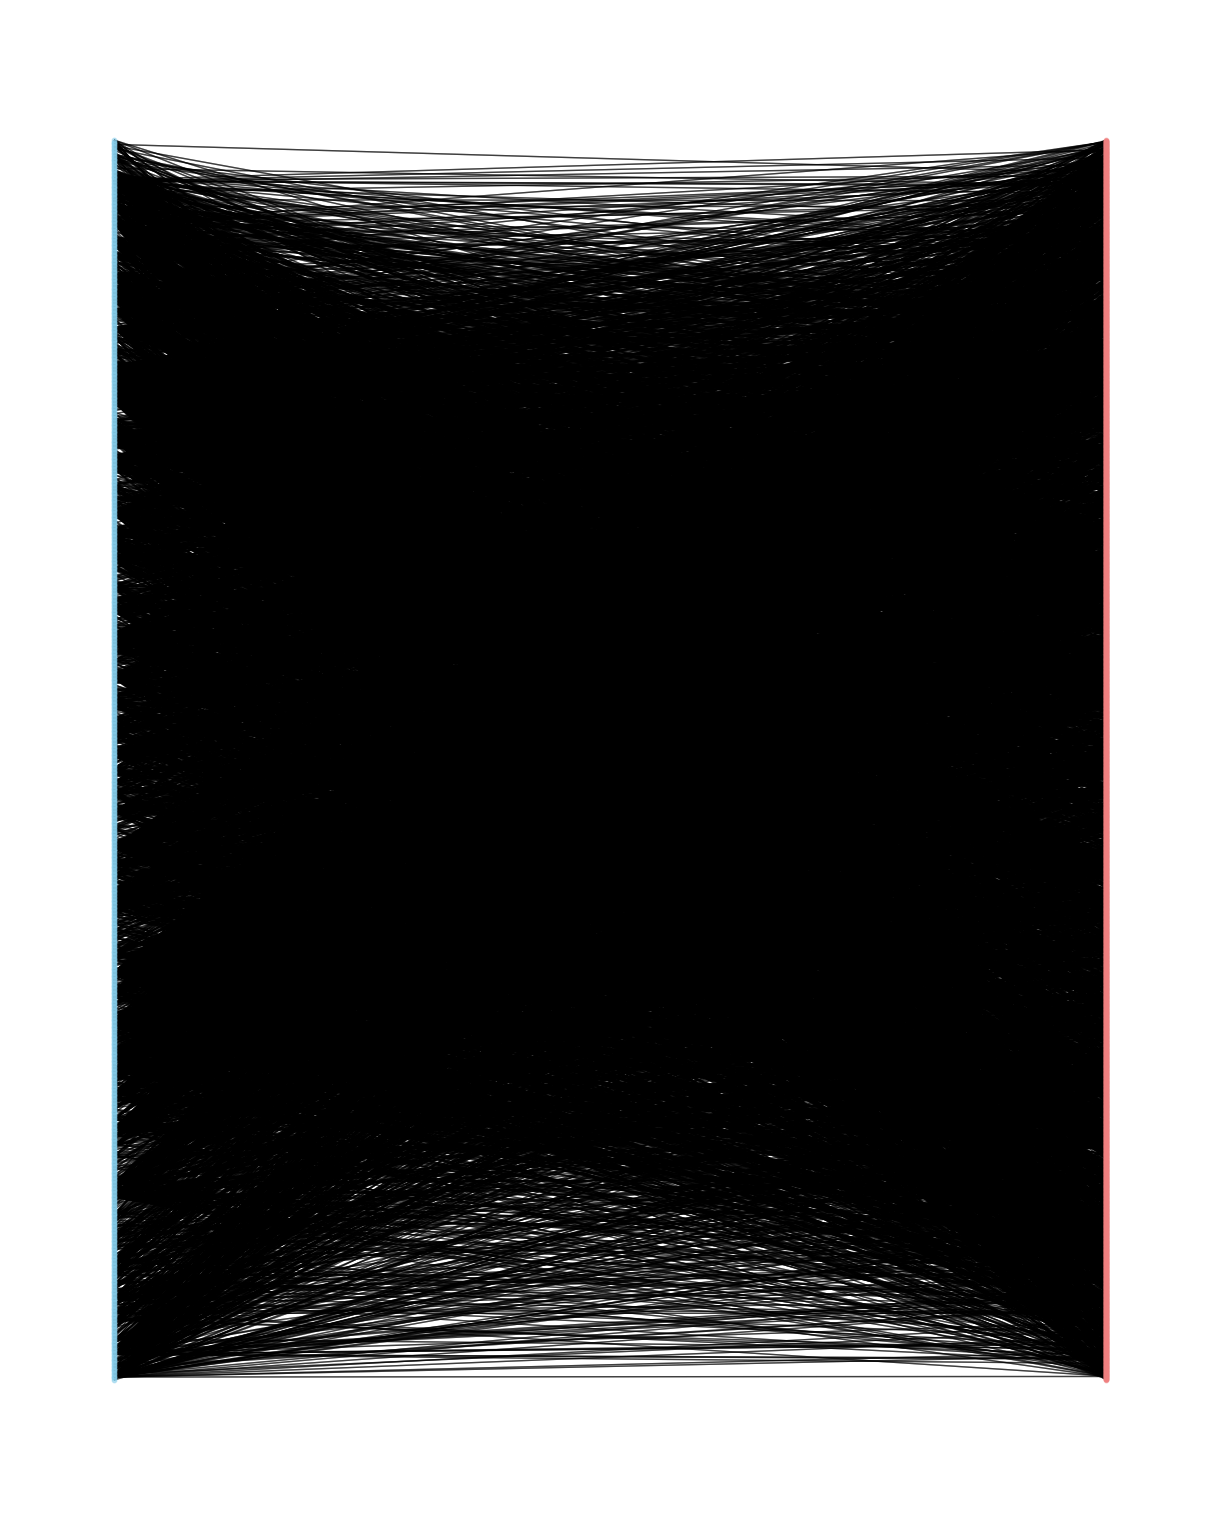

In [19]:
source_nodes = {node for node, data in total_network.nodes(data=True)
                      if data['bipartite'] == 1}
sharer_nodes = {node for node, data in total_network.nodes(data=True) 
                if data['bipartite'] == 0}

fn = "total network bipartite"
plot_bipartite(total_network, source_nodes, sharer_nodes, fn=fn)

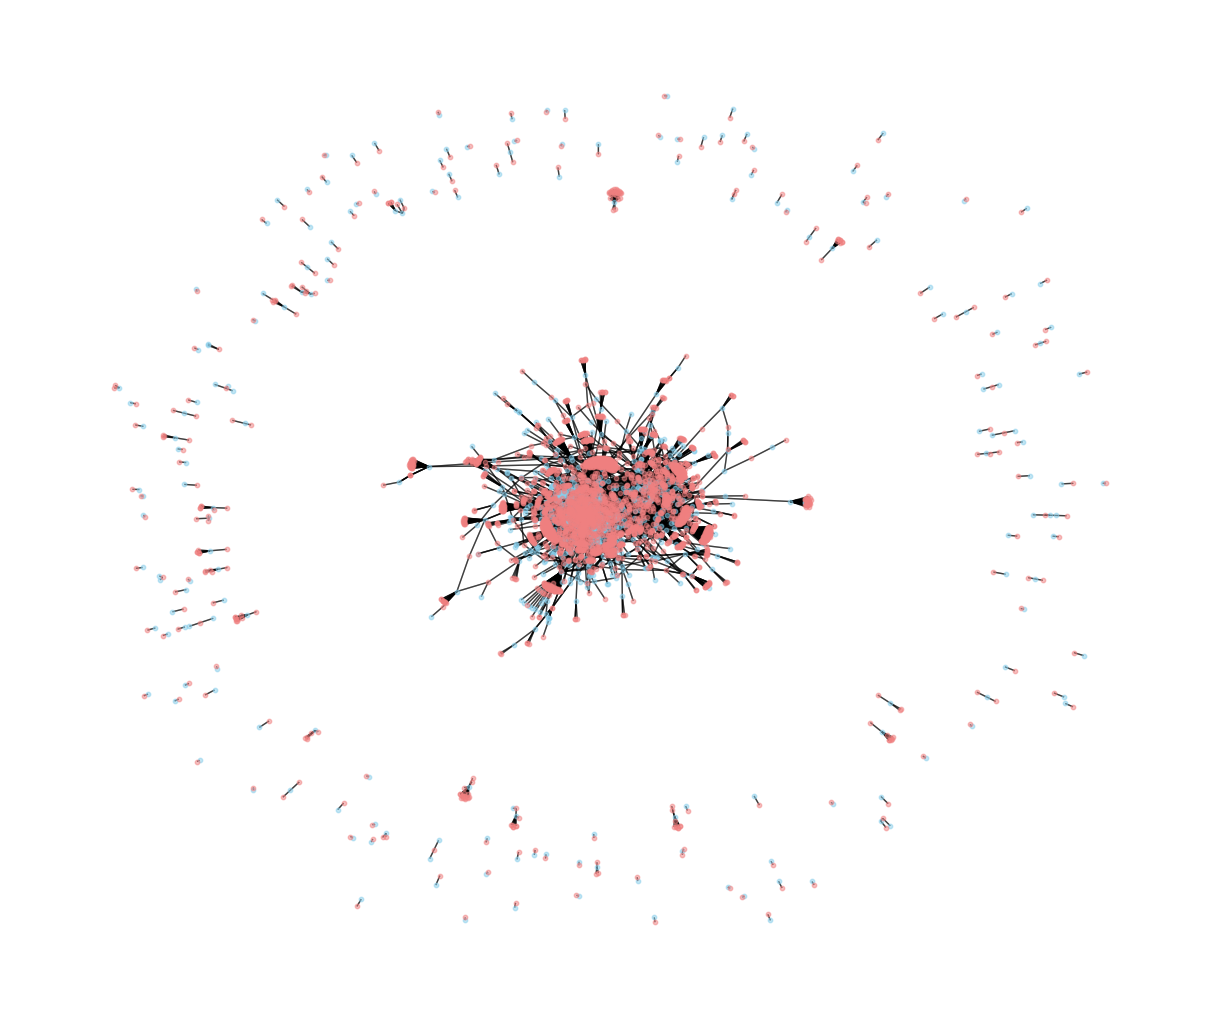

In [20]:
fn = "total network spring"
plot_bipartite(total_network, source_nodes, sharer_nodes, fn=fn, bipartite_layout=False)

In [21]:
shared_audience_network, shared_source_network = create_projections(total_network, source_nodes, sharer_nodes)

### shared audience network

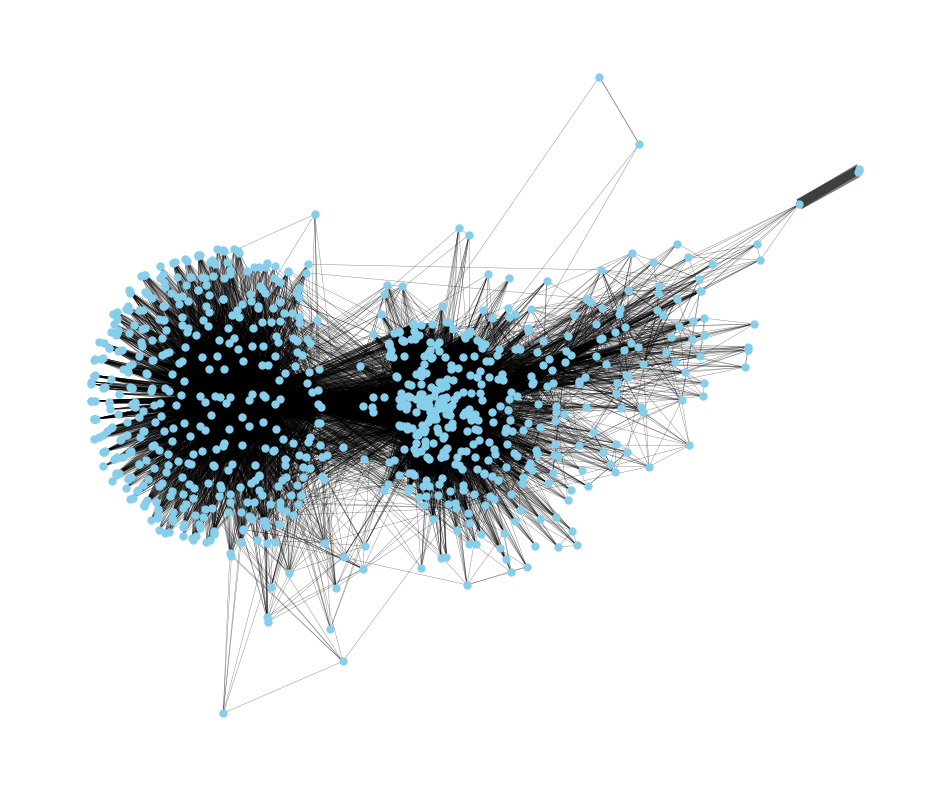

In [22]:
filtered_shared_audience_network = filter_network(shared_audience_network, min_degree_threshold=10)
joblib.dump(filtered_shared_audience_network, 'total-shared-audience.pkl')

fn = 'total network shared audience filtered'
plot_network(filtered_shared_audience_network, fn=fn)

Network Density: 0.01
Clustering Coefficient: 0.59
Average Degree: 21.51


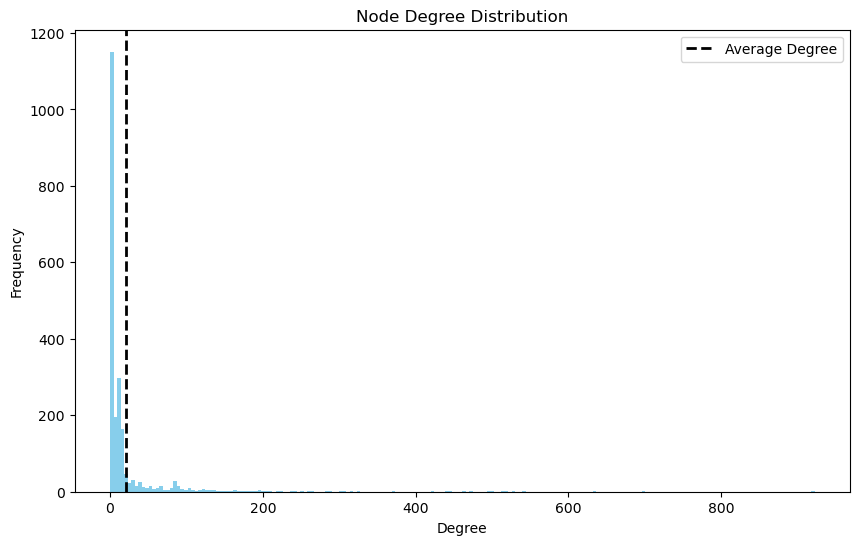

In [23]:
network_statistics(shared_audience_network, color='skyblue')

Network Density: 0.06
Average Shortest Path Length: 2.12
Clustering Coefficient: 0.80
Average Degree: 48.67


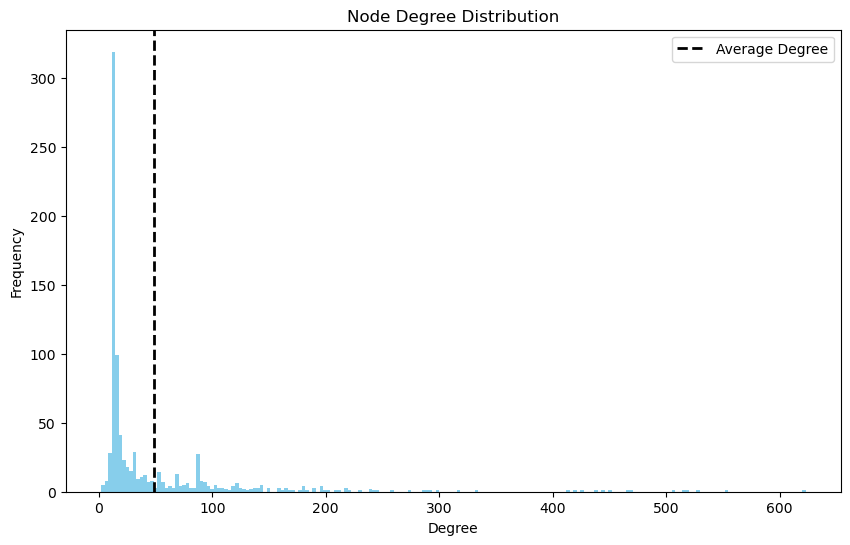

In [24]:
network_statistics(filtered_shared_audience_network, color='skyblue')

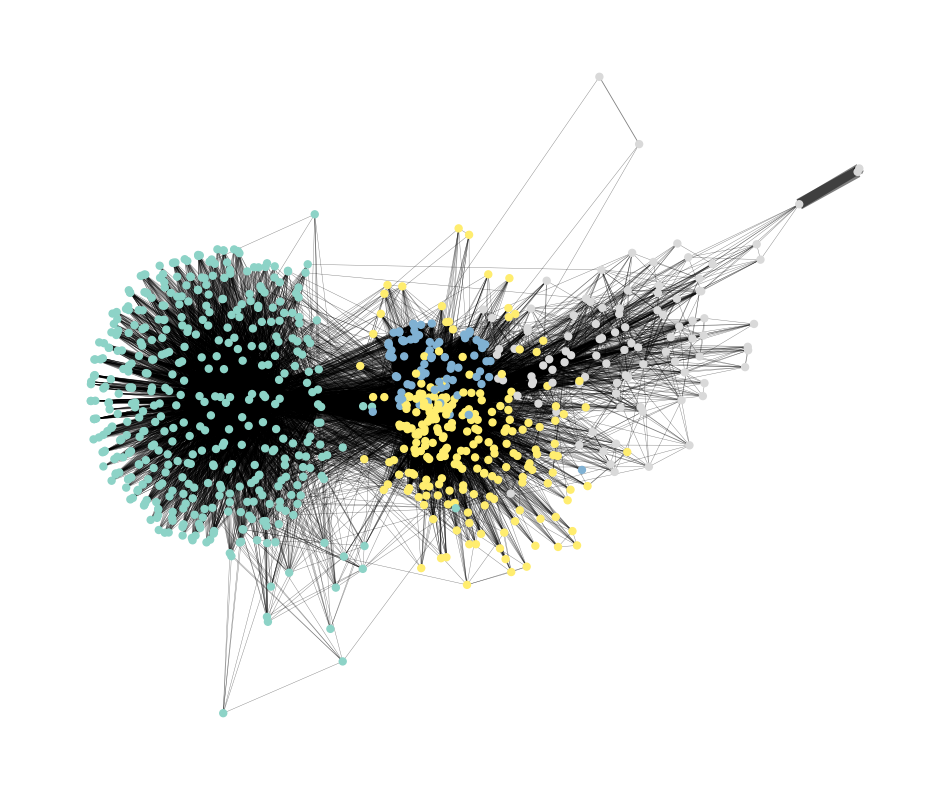

In [25]:
fn = 'total network shared audience clustered'
shared_aud_comm = plot_network(filtered_shared_audience_network, fn=fn, cmap=plt.cm.Set3, show_communities=True)

In [26]:
sa_community_sizes, sa_degree, sa_between, sa_eigen = get_influential_nodes(
    filtered_shared_audience_network, n=20, community_labels=shared_aud_comm
)


By degree centrality:



0  \
0           architectsforLeni   
1                pinoyakoblog   
2             batas4everyjuan   
3            inutilfreePH2022   
4          iMPACTLeadershipPH   
5      WeSupportVPLeniRobredo   
6            DavaoParaKayLeni   
7          kabataan.tropa2022   
8   europeforleniforpresident   
9           pilipinongpalaban   
10              0rasNaR0xasNa   
11            VPLeniRobredoPH   
12          repforlenirobredo   
13      newsinfo.inquirer.net   
14         NeverAgainToMarcos   
15         Facebook profile:    
16             Iriga for Leni   
17    ABL - Angat Buhay Lahat   
18                  ofw.page2   
19     PUP Community for Leni   

                                                    1  \
0                               Facebook profile: Joy   
1                                      groups/kvbcebu   
2                            Facebook profile: Gnothi   
3                          Facebook profile: Spitzkat   
4                                      solidleniticao   
5                                    1299387130209232   
6                    Facebook profile: Team Pilipinas   
7                                Facebook profile: Al   
8                                          JuanLunaJL   
9                                  www.gmanetwork.com   
10                                     thefreemannews   
11                                    www.rappler.com   
12                                         1111250335   
13                                    100001997813704   
14                                            JSP9968   
15                               valenzuelanosforleni   
16  Facebook profile: Photos from Ryan De Mesa Gui...   
17                                         1733617962   
18                                        mikee.gulla   
19                               Facebook profile: Rm   

                                                    2  \
0                        Facebook profile: Benjie Jr.   
1                         Facebook profile: Joe Smith   
2                               Facebook profile: Jay   
3                                     News5Everywhere   
4                                         uniteam2022   
5                                 TeamBBM2022Official   
6                              groups/xdu30supporters   
7                                          sabong2022   
8            Facebook profile: Blessed Be Philippines   
9                                     Politicaltambay   
10                                    111931427818864   
11        Facebook profile: I Support Bongbong Marcos   
12  Facebook profile: Partido Federal ng Pilipinas...   
13                                    100044205260834   
14                                      DaddyRicVlogs   
15                       Facebook profile: Kritikojep   
16                             teambongbonglizamarcos   
17                             groups/361859687501088   
18                         Facebook profile: Krizette   
19                                    110424151416423   

                                                 3  
0                           Facebook profile: Leni  
1                                   FactCheckPhils  
2                                  sananselmopress  
3                            Facebook profile: Jun  
4              Facebook profile: Akbayan Partylist  
5                                   inquirerdotnet  
6   Facebook profile: This is a re-share of a post  
7                     Facebook profile: Carlo Bonn  
8                            Facebook profile: Kim  
9                       Facebook profile: Reynaldo  
10                                         gmanews  
11                                  kayaphmovement  
12                                 teamlenirobredo  
13                               globaldailymirror  
14                                    nowyouknowph  
15                          IsabelaParaKayLeniKiko  
16                         Facebook p


By betweenness centrality:



0  \
0                                   architectsforLeni   
1                                        pinoyakoblog   
2                                    inutilfreePH2022   
3                              WeSupportVPLeniRobredo   
4                                     batas4everyjuan   
5                                  iMPACTLeadershipPH   
6                                    DavaoParaKayLeni   
7                                  kabataan.tropa2022   
8                           europeforleniforpresident   
9                                   pilipinongpalaban   
10                                      0rasNaR0xasNa   
11                                    VPLeniRobredoPH   
12                                  repforlenirobredo   
13                              newsinfo.inquirer.net   
14                                 Facebook profile:    
15                                     Iriga for Leni   
16                                          MakatiZen   
17                            ABL - Angat Buhay Lahat   
18  President Leni Robredo @ VP Kiko Pangilinan Ta...   
19                                 NeverAgainToMarcos   

                                   1  \
0                 www.gmanetwork.com   
1                     groups/kvbcebu   
2                   1299387130209232   
3              Facebook profile: Joy   
4           Facebook profile: Gnothi   
5          VPLeniRobredoForPresident   
6              Facebook profile: Doy   
7   Facebook profile: Team Pilipinas   
8       Facebook profile: Narciso Jr   
9               Facebook profile: Al   
10                        1733617962   
11                 ph.news.yahoo.com   
12                        1111250335   
13        Facebook profile: Spitzkat   
14         Facebook profile: Elpidio   
15          Facebook profile: Eduard   
16           BPOEmployeesForLeniKiko   
17                    solidleniticao   
18                           JSP9968   
19     Facebook profile: Ricardo Ric   

                                                    2  \
0                         Facebook profile: Joe Smith   
1                                     News5Everywhere   
2                               Facebook profile: Jay   
3                        Facebook profile: Benjie Jr.   
4                                         uniteam2022   
5                                 GoPhilippinesdotcom   
6                                 TeamBBM2022Official   
7            Facebook profile: Blessed Be Philippines   
8                                     100044205260834   
9                                          sabong2022   
10                                    100049771702561   
11                             teambongbonglizamarcos   
12        Facebook profile: I Support Bongbong Marcos   
13  Facebook profile: Partido Federal ng Pilipinas...   
14                             groups/394552232313320   
15                             groups/xdu30supporters   
16                               shierwin.estelailano   
17                          Facebook profile: Raymond   
18             Facebook profile: Bongbong Marcos Blog   
19                                  filipinocommunity   

                                                 3  
0                           Facebook profile: Leni  
1                                   FactCheckPhils  
2                                globaldailymirror  
3                            Facebook profile: Kim  
4                                  sananselmopress  
5                                   inquirerdotnet  
6              Facebook profile: Akbayan Partylist  
7                            Facebook profile: Jun  
8                           IsabelaParaKayLeniKiko  
9   Facebook profile: This is a re-share of a post  
10                      Facebook profile: Reynaldo  
11                                  kayaphmovement  
12                    Facebook profile: Carlo Bonn  
13                                         gmanews  
14                  


By eigenvector centrality:



0  \
0           architectsforLeni   
1                pinoyakoblog   
2             batas4everyjuan   
3          iMPACTLeadershipPH   
4            inutilfreePH2022   
5      WeSupportVPLeniRobredo   
6          kabataan.tropa2022   
7            DavaoParaKayLeni   
8       newsinfo.inquirer.net   
9   europeforleniforpresident   
10          pilipinongpalaban   
11              0rasNaR0xasNa   
12          repforlenirobredo   
13            VPLeniRobredoPH   
14     PUP Community for Leni   
15             Iriga for Leni   
16    ABL - Angat Buhay Lahat   
17         Facebook profile:    
18  VP LENI ROBREDO & Friends   
19         NeverAgainToMarcos   

                                                    1  \
0                               Facebook profile: Joy   
1                                      groups/kvbcebu   
2                            Facebook profile: Gnothi   
3                          Facebook profile: Spitzkat   
4                                      solidleniticao   
5                    Facebook profile: Team Pilipinas   
6                                Facebook profile: Al   
7                                      thefreemannews   
8                                          JuanLunaJL   
9                                     www.rappler.com   
10                                    100001997813704   
11                                   1299387130209232   
12                                         1111250335   
13                               valenzuelanosforleni   
14                                            JSP9968   
15  Facebook profile: Photos from Ryan De Mesa Gui...   
16                                        mikee.gulla   
17                               Facebook profile: Rm   
18  Facebook profile: Photos from Florentino A. He...   
19                                         1733617962   

                                           2  \
0               Facebook profile: Benjie Jr.   
1                      Facebook profile: Jay   
2                                uniteam2022   
3                            News5Everywhere   
4                Facebook profile: Joe Smith   
5                     groups/xdu30supporters   
6                            Politicaltambay   
7               Facebook profile: Kritikojep   
8                        TeamBBM2022Official   
9                            111931427818864   
10                    groups/361859687501088   
11                    teambongbonglizamarcos   
12                                sabong2022   
13    Facebook profile: Kapitan Solomon 2022   
14                                1103092027   
15                      shierwin.estelailano   
16                Facebook profile: Krizette   
17  Facebook profile: Blessed Be Philippines   
18                     Facebook profile: PTV   
19                           100044205260834   

                                                 3  
0                           Facebook profile: Leni  
1                                  sananselmopress  
2                                   FactCheckPhils  
3                            Facebook profile: Jun  
4   Facebook profile: This is a re-share of a post  
5              Facebook profile: Akbayan Partylist  
6                     Facebook profile: Carlo Bonn  
7                                   inquirerdotnet  
8                                  teamlenirobredo  
9                                          gmanews  
10                                    nowyouknowph  
11                                  kayaphmovement  
12                          groups/432801591542383  
13                           Facebook profile: Kim  
14                         Facebook profile: Terio  
15                         Facebook profile: Edgar  
16                 Facebook profile: Meilou Sereno  
17                      Facebook profile: Reynaldo  
18                                attyhowiecalleja  
19                       Facebook profile: Kheneth

In [27]:
sa_community_sizes

{0: 439, 1: 83, 2: 99, 3: 230}

### shared sources network

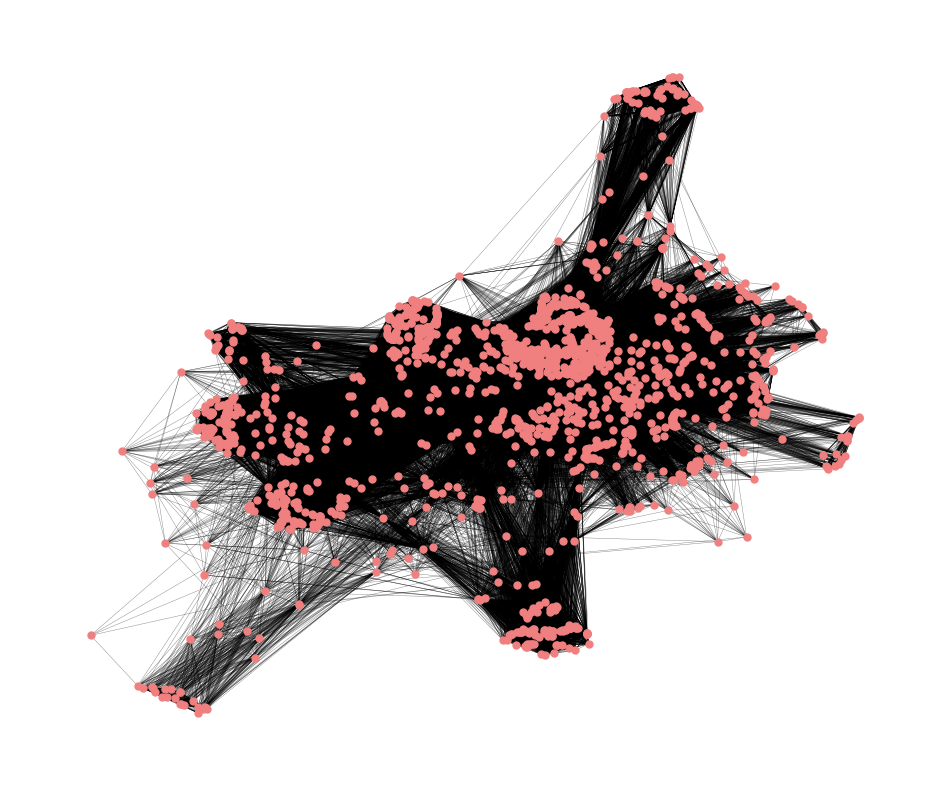

In [28]:
filtered_shared_source_network = filter_network(shared_source_network, min_degree_threshold=35)
joblib.dump(filtered_shared_source_network, 'total-shared-sources.pkl')

fn = 'total network shared source filtered'
plot_network(filtered_shared_source_network, fn=fn, color='lightcoral')

Network Density: 0.05
Clustering Coefficient: 0.83
Average Degree: 151.54


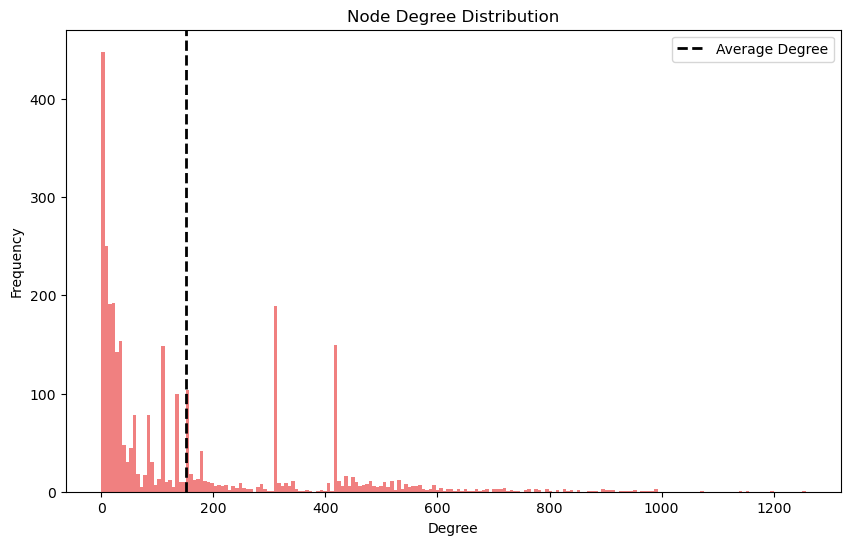

In [29]:
network_statistics(shared_source_network, color='lightcoral')

Network Density: 0.15
Average Shortest Path Length: 1.96
Clustering Coefficient: 0.88
Average Degree: 254.08


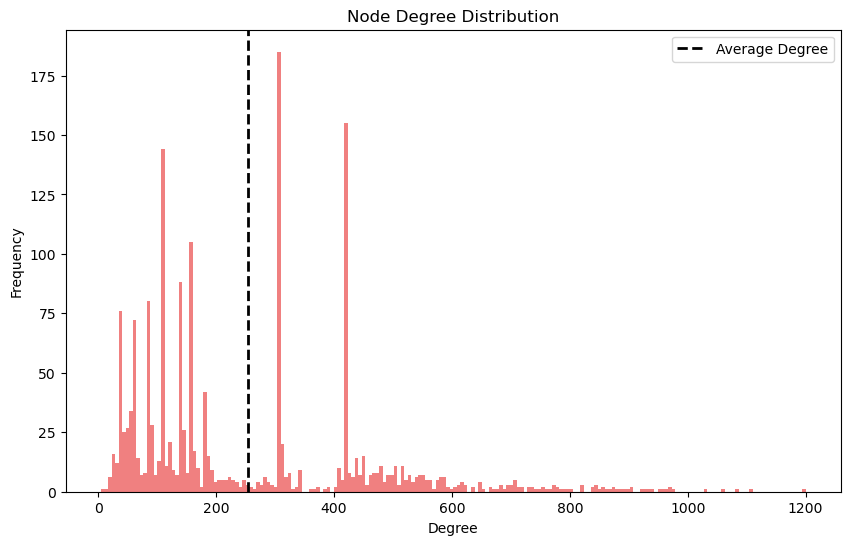

In [30]:
network_statistics(filtered_shared_source_network, color='lightcoral')

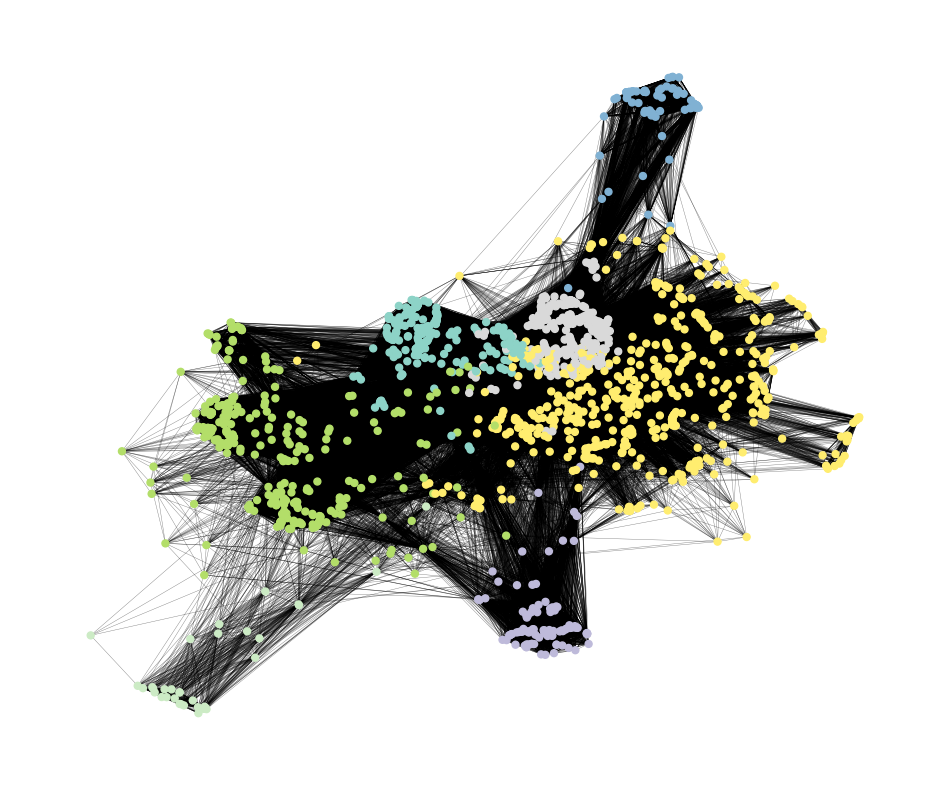

In [31]:
fn = 'total network shared source clustered'
shared_src_comm = plot_network(filtered_shared_source_network, fn=fn, cmap=plt.cm.Set3, show_communities=True)

In [32]:
ss_community_sizes, ss_degree, ss_between, ss_eigen = get_influential_nodes(
    filtered_shared_source_network, n=20, community_labels=shared_src_comm
)


By degree centrality:



0  \
0                            NUEVA ECIJA JOB HIRING   
1                      Society Of Freedom Advocates   
2                   Leni Robredo for President 2022   
3                    Pinoys abroad for LENI ROBREDO   
4                           Leni Robredo supporters   
5                                   TAGA BICOL KAMI   
6                       Pasig City for Leni Robredo   
7                                VP LENI SUPPORTERS   
8                    KakamPink ni Leni Robredo 2022   
9                 #LeniKiko2022...Sulong Pilipinas!   
10                 SOBRA NA! TAMA NA! LABANAN NA!!!   
11                  MARINDUQUEÑOS for Leni-Kiko2022   
12                                     pinoyakoblog   
13                 PEOPLE & POLITICS in PHILIPPINES   
14                 LENI ROBREDO FOR PRESIDENT 2022"   
15  Leni for President Movement Quezon City Chapter   
16                                Ilonggos for Leni   
17               Movement for Freedom and Democracy   
18            Gobyernong Tapat, Angat Buhay Lahat 💗   
19         LENI ROBREDO for PRESIDENT MOVEMENT 2022   

                                                    1  \
0                           Filipino Ofw in SINGAPORE   
1                                Filipinos In The UAE   
2         OFW / SEAMAN Universal tambayan at bentahan   
3                          Mga Filipino OFW sa Israel   
4                               Pulitika Sa Pilipinas   
5                                   OFW KABAYAN GROUP   
6                                       PHILIPPINE TV   
7                          Mga Filipino OFW sa France   
8   RODANTE D. MARCOLETA  Movement for Good Govern...   
9       YORME ISKO MORENO for PRESIDENT 2022 MOVEMENT   
10                     OFW @ Kingdom Of Saudi Arabia…   
11                               Small YouTubers PH🇵🇭   
12                                ACTIVE LIKERS ONLY✅   
13                              YOUTUBE SUPPORT GROUP   
14              United Isko Moreno for President 2022   
15                                  PUSO ng PILIPINAS   
16                             Isko Moreno supporters   
17                    MGA TAGA  BICOL  KITA, ORAGON!!   
18              OFW - Caregivers from the Philippines   
19                                    OFW Philippines   

                                     2  \
0   LeapersForLeniKikoAndSenatoriables   
1                      AbraForLeniKiko   
2                       meiloupasereno   
3                         Franco121076   
4                     democracywatchph   
5                  ElectionWatchPH2022   
6                             ExposePH   
7                 noctilucouslogophile   
8                      MyTeamPilipinas   
9                       EvenDemata2021   
10                    yormengpilipinas   
11                     mindanaoinsider   
12              bbmsara2022bangonpinas   
13                     KaalamanPHMedia   
14                  bongbongmarcos2022   
15                    PNGPRIMEMINISTER   
16                       CJ0305FOREVER   
17                           upalyansa   
18                        RBSFMBacolod   
19           marapebasilgovernmentfans   

                                                    3  \
0                                OFW AROUND THE WORLD   
1                    Election 2022 Survey Philippines   
2                              SEAMAN  URGENT APPLYAN   
3                   Tambayan Sa Akasya ng Guinayangan   
4                   KAMPILAN PEACEKEEPERS ASSOCIATION   
5              Mga taga Sibalom, Antique, Philippines   
6   BBM2022 Supporters Group (Bangon Bayang Maharl...   
7                               KAY LENI ROBREDO KAMI   
8        ABS-CBN Kapamilya Community Updates and News   
9                             DUGONG SIPALAYNON GROUP   
10                        BBMSOLID for Pres. NATIONAL   
11                                      Roxas Isabela   
12                               Taga Corella Jud Ko!   
13             


By betweenness centrality:



0  \
0                                   TAGA BICOL KAMI   
1                                Opinyon at Kritiko   
2                DUTERTE _Agila ng Pilipinas 🦅🦅🇵🇭🇵🇭   
3                      the supporters para sa bayan   
4                     UKAY LIVE SELLING PHILIPPINES   
5                            NUEVA ECIJA JOB HIRING   
6        OVERSEAS FILIPINO WORKERS: ONLINE BUSINESS   
7                                      Public Group   
8                   Leni Robredo for President 2022   
9                 #LeniKiko2022...Sulong Pilipinas!   
10                     Society Of Freedom Advocates   
11                      Pasig City for Leni Robredo   
12                          Leni Robredo supporters   
13                                  Ex-BBM for LENI   
14                 SOBRA NA! TAMA NA! LABANAN NA!!!   
15                   Pinoys abroad for LENI ROBREDO   
16                               VP LENI SUPPORTERS   
17  Leni for President Movement Quezon City Chapter   
18               ISKO MORENO FOR PRESIDENT MOVEMENT   
19                   KakamPink ni Leni Robredo 2022   

                                                    1  \
0                           Filipino Ofw in SINGAPORE   
1         OFW / SEAMAN Universal tambayan at bentahan   
2                                Filipinos In The UAE   
3                               Pulitika Sa Pilipinas   
4                          Mga Filipino OFW sa Israel   
5                                       PHILIPPINE TV   
6                                   OFW KABAYAN GROUP   
7                          Mga Filipino OFW sa France   
8   RODANTE D. MARCOLETA  Movement for Good Govern...   
9       YORME ISKO MORENO for PRESIDENT 2022 MOVEMENT   
10                     OFW @ Kingdom Of Saudi Arabia…   
11              United Isko Moreno for President 2022   
12                                  PUSO ng PILIPINAS   
13                             Isko Moreno supporters   
14                               Small YouTubers PH🇵🇭   
15                                ACTIVE LIKERS ONLY✅   
16                              YOUTUBE SUPPORT GROUP   
17                    MGA TAGA  BICOL  KITA, ORAGON!!   
18              OFW - Caregivers from the Philippines   
19                                    OFW Philippines   

                                     2  \
0   LeapersForLeniKikoAndSenatoriables   
1                       meiloupasereno   
2                      AbraForLeniKiko   
3                  ElectionWatchPH2022   
4                             ExposePH   
5                 noctilucouslogophile   
6                         Franco121076   
7                     democracywatchph   
8                       EvenDemata2021   
9                      MyTeamPilipinas   
10                    yormengpilipinas   
11                     mindanaoinsider   
12              bbmsara2022bangonpinas   
13                     KaalamanPHMedia   
14                  bongbongmarcos2022   
15                    PNGPRIMEMINISTER   
16                       CJ0305FOREVER   
17                           upalyansa   
18                        RBSFMBacolod   
19           marapebasilgovernmentfans   

                                                    3  \
0                                OFW AROUND THE WORLD   
1                   KAMPILAN PEACEKEEPERS ASSOCIATION   
2                   Tambayan Sa Akasya ng Guinayangan   
3                    Election 2022 Survey Philippines   
4                              SEAMAN  URGENT APPLYAN   
5   BBM2022 Supporters Group (Bangon Bayang Maharl...   
6              Mga taga Sibalom, Antique, Philippines   
7                                      PRO-GOVERNMENT   
8                           OFW Community SWITZERLAND   
9                    BONGBONG MARCOS SULONG PILIPINAS   
10          PHILIPPINE FEDERAL MOVEMENT INTERNATIONAL   
11          𝗕𝗔𝗧𝗔𝗡𝗚 𝗠𝗔𝗬𝗡𝗜𝗟𝗔, 𝗜𝘀𝗮𝗻𝗴 𝗕𝗮𝗻𝘀𝗮, 𝗜𝘀𝗮𝗻𝗴 𝗕𝗮𝗻𝗴𝗸𝗮   
12                              KAY LENI ROBREDO KAMI   
13       ABS-CB


By eigenvector centrality:



0  \
0                      Society Of Freedom Advocates   
1                    Pinoys abroad for LENI ROBREDO   
2                           Leni Robredo supporters   
3                    KakamPink ni Leni Robredo 2022   
4                                VP LENI SUPPORTERS   
5                            NUEVA ECIJA JOB HIRING   
6                   Leni Robredo for President 2022   
7                  PEOPLE & POLITICS in PHILIPPINES   
8                       Pasig City for Leni Robredo   
9                   MARINDUQUEÑOS for Leni-Kiko2022   
10                 LENI ROBREDO FOR PRESIDENT 2022"   
11                #LeniKiko2022...Sulong Pilipinas!   
12                                     pinoyakoblog   
13  Leni for President Movement Quezon City Chapter   
14                 SOBRA NA! TAMA NA! LABANAN NA!!!   
15                                Ilonggos for Leni   
16            Gobyernong Tapat, Angat Buhay Lahat 💗   
17               Movement for Freedom and Democracy   
18         LENI ROBREDO for PRESIDENT MOVEMENT 2022   
19                              Pet Lovers for Leni   

                                                    1  \
0                           Filipino Ofw in SINGAPORE   
1                                Filipinos In The UAE   
2         OFW / SEAMAN Universal tambayan at bentahan   
3                          Mga Filipino OFW sa Israel   
4                               Pulitika Sa Pilipinas   
5                          Mga Filipino OFW sa France   
6                                       PHILIPPINE TV   
7                                   OFW KABAYAN GROUP   
8   RODANTE D. MARCOLETA  Movement for Good Govern...   
9       YORME ISKO MORENO for PRESIDENT 2022 MOVEMENT   
10                               Small YouTubers PH🇵🇭   
11                                ACTIVE LIKERS ONLY✅   
12                              YOUTUBE SUPPORT GROUP   
13                     OFW @ Kingdom Of Saudi Arabia…   
14                    MGA TAGA  BICOL  KITA, ORAGON!!   
15              OFW - Caregivers from the Philippines   
16                                    OFW Philippines   
17                    Philippine Caregivers Singapore   
18                                   TAIWAN OFW GROUP   
19                    OFW inn kuwait have a great day   

                                     2  \
0   LeapersForLeniKikoAndSenatoriables   
1                      AbraForLeniKiko   
2                       meiloupasereno   
3                         Franco121076   
4                     democracywatchph   
5                      MyTeamPilipinas   
6                  ElectionWatchPH2022   
7                             ExposePH   
8                 noctilucouslogophile   
9                       EvenDemata2021   
10                    yormengpilipinas   
11                     mindanaoinsider   
12              bbmsara2022bangonpinas   
13                     KaalamanPHMedia   
14                  bongbongmarcos2022   
15                    PNGPRIMEMINISTER   
16                       CJ0305FOREVER   
17                           upalyansa   
18                        RBSFMBacolod   
19           marapebasilgovernmentfans   

                                                    3  \
0                                OFW AROUND THE WORLD   
1                              SEAMAN  URGENT APPLYAN   
2                   Tambayan Sa Akasya ng Guinayangan   
3                    Election 2022 Survey Philippines   
4              Mga taga Sibalom, Antique, Philippines   
5                   KAMPILAN PEACEKEEPERS ASSOCIATION   
6                               KAY LENI ROBREDO KAMI   
7        ABS-CBN Kapamilya Community Updates and News   
8                             DUGONG SIPALAYNON GROUP   
9                         #SwitchToIsko (Guiuananons)   
10                                        BARMM-WATCH   
11                                      Roxas Isabela   
12                        BBMSOLID for Pres. NATIONAL   
13  BBM2022 Sup

In [33]:
ss_community_sizes

{0: 282, 1: 103, 2: 76, 3: 333, 4: 337, 5: 34, 6: 549}

## save output

In [36]:
def save_network_data_to_csv(network, community_labels, nodes_csv_path, links_csv_path):
    """
    Calculate centrality measures for nodes in the network and save the node and edge data to CSV files.

    Parameters:
        network (networkx.Graph): The input network represented as a networkx graph.
        community_labels (dict): A dictionary containing community labels for each node in the network.
                                 The keys are node identifiers, and the values are community labels.
        nodes_csv_path (str): The file path where the node data will be saved in CSV format.
        links_csv_path (str): The file path where the edge data will be saved in CSV format.

    """
    nx.set_node_attributes(network, community_labels, name='community')

    degree_centrality = nx.degree_centrality(network)
    betweenness_centrality = nx.betweenness_centrality(network)
    eigenvector_centrality = nx.eigenvector_centrality(network)

    node_data = {node: {
        "community": community_label,
        "degree_centrality": degree_centrality[node],
        "betweenness_centrality": betweenness_centrality[node],
        "eigenvector_centrality": eigenvector_centrality[node]
    } for node, community_label in network.nodes(data="community")}

    nodes_df = pd.DataFrame.from_dict(node_data, orient="index")

    edges_data = [(source, target) for source, target in network.edges()]
    links_df = pd.DataFrame(edges_data, columns=["source", "target"])

    nodes_df.to_csv(nodes_csv_path, index_label="node_id")
    links_df.to_csv(links_csv_path, index=False)

In [37]:
save_network_data_to_csv(filtered_shared_source_network, shared_src_comm,
                    "shared_sources_nodes.csv", "shared_sources_links.csv")

In [38]:
save_network_data_to_csv(filtered_shared_audience_network, shared_aud_comm,
                    "shared_audience_nodes.csv", "shared_audience_links.csv")